In [ ]:
from typing import Literal
from typing_extensions import TypedDict

from langchain_openai import ChatOpenAI
from langgraph.graph import MessagesState, END
from langgraph.types import Command
import os
from langchain_anthropic import ChatAnthropic


members = ["english speaker", "french speaker"]
options = members

system_prompt = (
    """You are a supervisor tasked with managing a conversation between the following workers: {members}. 
    If the question is in French, send it to the French speaker. If it's in English, send it to the English speaker."""
)


class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal[*options]


llm_english = ChatOpenAI(base_url=os.environ.get("SCW_GENERATIVE_APIs_ENDPOINT"),api_key=os.environ.get("SCW_SECRET_KEY_PERSO"),model="llama-3.1-70b-instruct")
llm_french = ChatOpenAI(base_url=os.environ.get("SCW_GENERATIVE_APIs_ENDPOINT"),api_key=os.environ.get("SCW_SECRET_KEY_PERSO"),model="llama-3.1-8b-instruct")


# llm_english = ChatAnthropic(model="claude-3-5-sonnet-latest")
# llm_french = ChatAnthropic(model="claude-3-5-sonnet-latest")

class State(MessagesState):
    next: str


def supervisor_node(state: State) -> Command[Literal[*members]]:
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    response = llm_english.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    return Command(goto=goto, update={"next": goto})

In [ ]:
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import create_react_agent


english_agent = create_react_agent(
    llm_english, tools=[]
)


def worker_english(state: State) -> Command[Literal["__end__"]]:
    result = english_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content)
            ]
        },
        goto=END,
    )


french_agent = create_react_agent(llm_french, tools=[])


def worker_french(state: State) -> Command[Literal["__end__"]]:
    result = french_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content)
            ]
        },
        goto=END,
    )


builder = StateGraph(State)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("english speaker", worker_english)
builder.add_node("french speaker", worker_french)
graph = builder.compile()

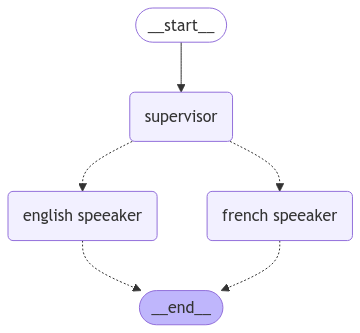

In [36]:
from IPython.display import display, Image
display(Image(graph.get_graph().draw_mermaid_png()))

In [37]:
for s in graph.stream(
    {"messages": [("user", "Donne moi une question de culture general.")]},
    subgraphs=True,
):
    print(s)
    print("----")

((), {'supervisor': {'next': 'english speeaker'}})
----
(('english speeaker:c016d7fc-6154-1e44-15a2-778192d8c8ea',), {'agent': {'messages': [AIMessage(content='Qui est l\'auteur du célèbre roman "1984" ?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 106, 'total_tokens': 122, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'meta/llama-3.1-70b-instruct:fp8', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-9421577f-612b-4707-953c-829caf1e2355-0', usage_metadata={'input_tokens': 106, 'output_tokens': 16, 'total_tokens': 122, 'input_token_details': {}, 'output_token_details': {}})]}})
----
((), {'english speeaker': {'messages': [HumanMessage(content='Qui est l\'auteur du célèbre roman "1984" ?', additional_kwargs={}, response_metadata={})]}})
----


In [38]:
for s in graph.stream(
    {"messages": [("user", "Give me a general culture question")]},
    subgraphs=True,
):
    print(s)
    print("----")

((), {'supervisor': {'next': 'english speeaker'}})
----
(('english speeaker:50d6b7e3-9eb9-12d2-fdb9-a42089424f75',), {'agent': {'messages': [AIMessage(content='Who is the author of the famous novel "To Kill a Mockingbird"?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 103, 'total_tokens': 120, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'meta/llama-3.1-70b-instruct:fp8', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-90010405-3486-4bd3-8932-9f16b78f7888-0', usage_metadata={'input_tokens': 103, 'output_tokens': 17, 'total_tokens': 120, 'input_token_details': {}, 'output_token_details': {}})]}})
----
((), {'english speeaker': {'messages': [HumanMessage(content='Who is the author of the famous novel "To Kill a Mockingbird"?', additional_kwargs={}, response_metadata={})]}})
----
